# Dynamic Planning  
分類 : 価値反復法
-  モデルベース  
-  価値ベース  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

from functions import possible_a, soft_max_policy, get_s_next #epsilon_greedy

In [3]:
def epsilon_greedy(Q, eps=0.3):
    pi = np.zeros_like(Q)
    for s in range(Q.shape[0]):
        Q_s = [Q[s,j] if possible_a[s,j]==1 else 0 for j in range(Q.shape[1])]
        #行動が一つしかとれない場合の例外処理
        if np.count_nonzero(possible_a[s,:] == 1) == 1:
            pi[s, np.argmax(possible_a[s,:])] = 1
            continue
        #一般的な処理
        for a in range(Q.shape[1]):
            if possible_a[s,a] == 0:
                continue
            else:
                pi[s, a] = eps / np.count_nonzero(possible_a[s,:] == 1)
        pi[s, np.argmax(Q_s)] += 1 - eps  
    return pi

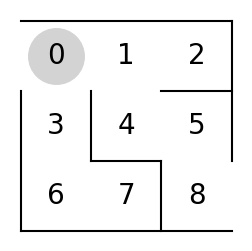

In [4]:
#迷路作成
fig = plt.figure(figsize=(3,3))

#壁
plt.plot([0, 3], [3, 3], color="k")
plt.plot([0, 3], [0, 0], color="k")
plt.plot([0, 0], [0, 2], color="k")
plt.plot([3, 3], [1, 3], color="k")
plt.plot([1, 1], [1, 2], color="k")
plt.plot([2, 3], [2, 2], color="k")
plt.plot([2, 1], [1, 1], color="k")
plt.plot([2, 2], [0, 1], color="k")

#数字
for i in range(3):
    for j in range(3):
        plt.text(0.5+i, 2.5-j, str(i+j*3), size=20, ha="center", va="center")

#円
circle, = plt.plot([0.5], [2.5], marker="o", color="#d3d3d3", markersize="40")

#メモリと枠の非表示
plt.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="off", right="off", left="off", labelleft="off")
plt.box("off")
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)



## 環境についての情報

In [5]:
#可能な行動のリスト
# possible_a

#状態遷移確率
# p_t = 1

#報酬関数g
g = np.zeros((9,4))
g[8,1] = 1 

#初期状態分布 s=0から

In [6]:
class ValueIteration:
    def __init__(self, ganma, eps=0.1) -> None:
        self.ganma = ganma
        self.eps = eps
        
    def B_asterisk(self, Q):
        Q_next = Q.copy()
        for s in range(Q.shape[0]):
            for a in range(Q.shape[1]):
                if [s,a] == [8,1]:
                    Q_next[s,a] = g[s,a]
                elif not get_s_next(s,a) == None:
                    Q_next[s,a] = g[s,a] + self.ganma * np.max(Q[get_s_next(s,a), :])
        delta = np.sum(Q_next - Q)
        return Q_next, delta
    def learning_B_asterisk(self, epoch, stop_epsilon):
        Q = np.zeros((9,4))
        delta_l = []
        for episode in range(epoch):
            Q, delta = self.B_asterisk(Q=Q,)
            delta_l.append(delta)
            if delta < stop_epsilon:
                break
        return Q, delta_l
    
    def B_pi(self, Q, pi):
        pi_table = pi(Q=Q)
        Q_next = Q.copy()
        for s in range(Q.shape[0]):
            for a in range(Q.shape[1]):
                if [s,a] == [8,1]:
                    Q_next[s,a] = g[s,a]
                elif not get_s_next(s,a) == None:
                        Q_next[s,a] = g[s,a] + self.ganma *  np.sum(pi_table[get_s_next(s,a),:] * Q[get_s_next(s,a), :])
        delta = np.sum(Q_next - Q)
        return Q_next, delta
    
    def learning_B_pi(self, pi, epoch, stop_epsilon):
        Q = np.zeros((9,4))
        delta_l = []
        for episode in range(epoch):
            Q, delta = self.B_pi(Q=Q, pi=pi)
            delta_l.append(delta)
            if delta < stop_epsilon:
                break
        return Q, delta_l

In [7]:
# vi = ValueIteration(ganma=0.9, eps=0.1)

# Q_pi, delta_pi = vi.learning_B_pi(pi=epsilon_greedy, epoch=1000, stop_epsilon=10e-3)
# Q_asterisk, delta_asterisk = vi.learning_B_asterisk(pi=epsilon_greedy, epoch=1000, stop_epsilon=10e-3)

In [8]:
def B_pi(Q, pi, ganma=0.9):
    pi_table = pi(Q=Q)
    Q_next = Q.copy()
    for s in range(Q.shape[0]):
        for a in range(Q.shape[1]):
            if [s,a] == [8,1]:
                Q_next[s,a] = g[s,a]
            elif not get_s_next(s,a) == None:
                    Q_next[s,a] = g[s,a] + ganma *  np.sum(pi_table[get_s_next(s,a),:] * Q[get_s_next(s,a), :])
    delta = np.sum(Q_next - Q)
    return Q_next, delta

In [9]:
def B_asterisk(Q, ganma=0.9):
    Q_next = Q.copy()
    for s in range(Q.shape[0]):
        for a in range(Q.shape[1]):
            if [s,a] == [8,1]:
                Q_next[s,a] = g[s,a]
            elif not get_s_next(s,a) == None:
                Q_next[s,a] = g[s,a] + ganma * np.max(Q[get_s_next(s,a), :])
    delta = np.sum(Q_next - Q)
    return Q_next, delta

In [10]:
def learning_B_asterisk(ganma=0.9, epoch=1000, stop_epsilon=10e-3, pi=None):
    Q = np.zeros((9,4))
    delta_l = []
    for episode in range(epoch):
        Q, delta = B_asterisk(Q=Q,)
        delta_l.append(delta)
        if delta < stop_epsilon:
            break
    return Q, delta_l

def learning_B_pi(ganma=0.9, epoch=1000, stop_epsilon=10e-3, pi=None):
    Q = np.zeros((9,4))
    delta_l = []
    for episode in range(epoch):
        Q, delta = B_pi(Q=Q, pi=pi)
        delta_l.append(delta)
        if delta < stop_epsilon:
            break
    return Q, delta_l

In [11]:
#最終的な方策
def pi_d(pi):
    pi_d = np.zeros(pi.shape[0])
    for s in range(pi.shape[0]):
        pi_s = pi[s, :]
        pi_d[s] = np.argmax(pi_s)
    return pi_d

In [12]:
Q_pi, pi_delta = learning_B_pi(B_pi, pi=epsilon_greedy, stop_epsilon=10e-5)
Q_asterisk, as_delta = learning_B_asterisk(B_asterisk, stop_epsilon=10e-5)

IndexError: index 9 is out of bounds for axis 0 with size 9

In [ ]:
pi_d1 = pi_d(Q_pi)
pi_d2 = pi_d(Q_asterisk)

print("Q_pi")
print(Q_pi)
print(pi_d1)

print()
print("Q_asterisk")
print(Q_asterisk)
print(pi_d2)

print()
print(f"answer \n[1, 2, 3, 0, 1, 2, 0, 3, 1]")

Q_pi
[[0.         0.62717874 0.49757892 0.        ]
 [0.         0.56446037 0.70653106 0.55862802]
 [0.         0.         0.         0.62717874]
 [0.55862802 0.         0.44337678 0.        ]
 [0.62717874 0.79334276 0.         0.        ]
 [0.         0.         0.89070042 0.70653106]
 [0.49757892 0.3990391  0.         0.        ]
 [0.         0.         0.         0.44337678]
 [0.79334276 1.         0.         0.        ]]
[1. 2. 3. 0. 1. 2. 0. 3. 1.]

Q_asterisk
[[0.         0.6561     0.531441   0.        ]
 [0.         0.59049    0.729      0.59049   ]
 [0.         0.         0.         0.6561    ]
 [0.59049    0.         0.4782969  0.        ]
 [0.6561     0.81       0.         0.        ]
 [0.         0.         0.9        0.729     ]
 [0.531441   0.43046721 0.         0.        ]
 [0.         0.         0.         0.4782969 ]
 [0.81       1.         0.         0.        ]]
[1. 2. 3. 0. 1. 2. 0. 3. 1.]

answer 
[1, 2, 3, 0, 1, 2, 0, 3, 1]


- 終了処理、一つしか行動がとれないときの例外処理を忘れていたためエラーが多かった
- epsilonが0.1だと状態７に到達しなかったが、0.3にすると７も訪問し、最適解を導けていた。
- B*の方が安定している
- B_piは収束は早いが、局所解に陥ることがある！

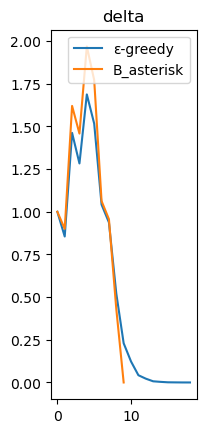

In [ ]:
graph = plt.figure()


x = np.arange(len(pi_delta))
g1 = graph.add_subplot(1, 3, 1)
g1.plot(x, pi_delta, label="ε-greedy")
x = np.arange(len(as_delta))
g1.plot(x, as_delta, label="B_asterisk")
g1.set_title("delta")
g1.legend()

plt.savefig("./result/graph2.png")
plt.show()


In [ ]:
""" def animate(i):
    state = s_a_history[i][0]
    circle.set_data((state % 3) + 0.5, 2.5 - int(state/3))
    return circle

anim = animation.FuncAnimation(fig, animate, frames=len(s_a_history), interval=200, repeat=False)
HTML(anim.to_jshtml()) """

' def animate(i):\n    state = s_a_history[i][0]\n    circle.set_data((state % 3) + 0.5, 2.5 - int(state/3))\n    return circle\n\nanim = animation.FuncAnimation(fig, animate, frames=len(s_a_history), interval=200, repeat=False)\nHTML(anim.to_jshtml()) '